In [7]:
!pip install pulp
!pip install openpyxl

In [8]:
import pandas as pd
import numpy as np
from pulp import *
import matplotlib.pyplot as plt
import mlflow
import logging
logging.getLogger("mlflow").setLevel(logging.ERROR)
import random
random.seed(1447)
import warnings
warnings.filterwarnings("ignore")

In [9]:
pd.set_option('display.max_colwidth', 0)
pd.set_option('display.max_columns', None)
pd.options.display.max_seq_items = 2000
base_path = 'data'

## Import Data

#### Manufacturing variable costs

In [10]:
# Import Costs
manvar_costs = pd.read_excel(f"{base_path}/variable costs.xlsx", index_col = 0)
manvar_costs

,USA,GERMANY,JAPAN,BRAZIL,INDIA
Variable Costs ($/Unit),,,,,
USA,12,12,12,12,12
GERMANY,13,13,13,13,13
JAPAN,10,10,10,10,10
BRAZIL,8,8,8,8,8
INDIA,5,5,5,5,5


#### Freight costs

In [11]:
# Import Costs
freight_costs = pd.read_excel(f"{base_path}/freight costs.xlsx", index_col = 0)
freight_costs

,USA,GERMANY,JAPAN,BRAZIL,INDIA
Freight Costs ($/Container),,,,,
USA,0,1750,1100,2300,1254
GERMANY,1905,0,1231,2892,1439
JAPAN,2200,3250,0,6230,2050
BRAZIL,2350,3150,4000,0,4250
INDIA,1950,2200,3500,4200,0


#### Variable Costs

In [12]:
# Factory + Freight Variable Costs
var_cost = freight_costs/1000 + manvar_costs 
var_cost

,USA,GERMANY,JAPAN,BRAZIL,INDIA
Freight Costs ($/Container),,,,,
USA,12.000,13.75,13.100,14.300,13.254
GERMANY,14.905,13.00,14.231,15.892,14.439
JAPAN,12.200,13.25,10.000,16.230,12.050
BRAZIL,10.350,11.15,12.000,8.000,12.250
INDIA,6.950,7.20,8.500,9.200,5.000


#### Fixed Costs

In [13]:
# Factory Fixed Costs
fixed_costs = pd.read_excel(f"{base_path}/fixed cost.xlsx", index_col = 0)
fixed_costs

,LOW,HIGH
USA,6500,9500
GERMANY,4980,7270
JAPAN,6230,9100
BRAZIL,3230,4730
INDIA,2110,6160


#### Plants Capacity

In [14]:
# Two types of plants: Low Capacity and High Capacity Plant
cap = pd.read_excel(f"{base_path}/capacity.xlsx", index_col = 0)
cap

,LOW,HIGH
Capacity (kUnits/month),,
USA,500,1500
GERMANY,500,1500
JAPAN,500,1500
BRAZIL,500,1500
INDIA,500,1500


#### Demand 

In [15]:
# Demand by Market
demand = pd.read_excel(f"{base_path}/demand.xlsx", index_col = 0)
demand

,Demand
(Units/month),
USA,2800000
GERMANY,90000
JAPAN,1700000
BRAZIL,145000
INDIA,160000


---

## Initial Calculation 
(1 Scenario)

In [16]:
# Define Decision Variables
loc = ['USA', 'GERMANY', 'JAPAN', 'BRAZIL', 'INDIA']
size = ['LOW', 'HIGH']
plant_name = [(i,s) for s in size for i in loc]
prod_name = [(i,j) for i in loc for j in loc]   

# Initialize Class
model = LpProblem("Capacitated Plant Location Model", LpMinimize)


# Create Decision Variables
x = LpVariable.dicts("production_", prod_name,
                     lowBound=0, upBound=None, cat='continuous')
y = LpVariable.dicts("plant_", 
                     plant_name, cat='Binary')

# Define Objective Function
model += (lpSum([fixed_costs.loc[i,s] * y[(i,s)] * 1000 for s in size for i in loc])
          + lpSum([var_cost.loc[i,j] * x[(i,j)]   for i in loc for j in loc]))

# Add Constraints
for j in loc:
    model += lpSum([x[(i, j)] for i in loc]) == demand.loc[j,'Demand']
for i in loc:
    model += lpSum([x[(i, j)] for j in loc]) <= lpSum([cap.loc[i,s]*y[(i,s)] * 1000
                                                       for s in size])                                                 
                                                       
# Solve Model
model.solve()
print("Status: {}".format(LpStatus[model.status]))
print("Total Costs: {:,} ($/Month)".format(int(value(model.objective))))

# Results Plant (Boolean)
df_bool = pd.DataFrame(data = [y[plant_name[i]].varValue for i in range(len(plant_name))], index = [i + '-' + s for s in size for i in loc], 
                        columns = ['Plant Opening'])
df_bool

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /opt/conda/lib/python3.10/site-packages/pulp/solverdir/cbc/linux/64/cbc /tmp/38ceb3630f3e47648f1e1b920854344e-pulp.mps -timeMode elapsed -branch -printingOptions all -solution /tmp/38ceb3630f3e47648f1e1b920854344e-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 15 COLUMNS
At line 131 RHS
At line 142 BOUNDS
At line 153 ENDATA
Problem MODEL has 10 rows, 35 columns and 60 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 6.46805e+07 - 0.00 seconds
Cgl0004I processed model has 10 rows, 35 columns (10 integer (10 of which binary)) and 60 elements
Cbc0038I Initial state - 1 integers unsatisfied sum - 0.07
Cbc0038I Solution found of 6.53175e+07
Cbc0038I Relaxing continuous gives 6.5118e+07
Cbc0038I Before mini branch and bound, 9 integers at bound fixed and 21 continuous
Cbc0038I Full problem 10 row

,Plant Opening
USA-LOW,0.0
GERMANY-LOW,0.0
JAPAN-LOW,0.0
BRAZIL-LOW,0.0
INDIA-LOW,1.0
USA-HIGH,0.0
GERMANY-HIGH,0.0
JAPAN-HIGH,1.0
BRAZIL-HIGH,1.0
INDIA-HIGH,1.0


#### Plant Opening

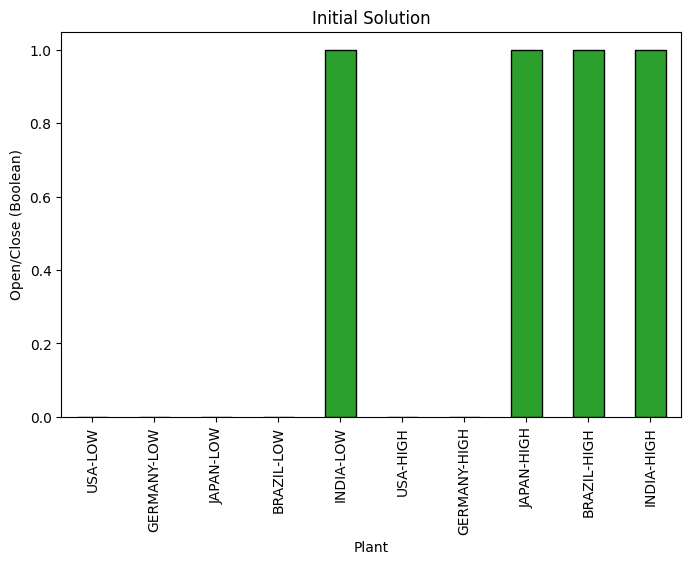

In [17]:
# Plant Opening
cap_plot = cap.copy()

ax = df_bool.astype(int).plot.bar(figsize=(8, 5), edgecolor='black', color = 'tab:green', y='Plant Opening', legend= False)
plt.xlabel('Plant')
plt.ylabel('Open/Close (Boolean)')
plt.title('Initial Solution')
plt.show()

---

### Functions to simulate several scenarios
#### Funtion to build the model

In [18]:
def optimization_model(fixed_costs, var_cost, demand, demand_col, cap):
    '''Build the optimization based on input parameters'''
    # Define Decision Variables
    loc = ['USA', 'GERMANY', 'JAPAN', 'BRAZIL', 'INDIA']
    size = ['LOW', 'HIGH']
    plant_name = [(i,s) for s in size for i in loc]
    prod_name = [(i,j) for i in loc for j in loc]   

    # Initialize Class
    model = LpProblem("Capacitated Plant Location Model", LpMinimize)

    # Create Decision Variables
    x = LpVariable.dicts("production_", prod_name,
                         lowBound=0, upBound=None, cat='continuous')
    y = LpVariable.dicts("plant_", 
                         plant_name, cat='Binary')

    # Define Objective Function
    model += (lpSum([fixed_costs.loc[i,s] * y[(i,s)] * 1000 for s in size for i in loc])
              + lpSum([var_cost.loc[i,j] * x[(i,j)]   for i in loc for j in loc]))

    # Add Constraints
    for j in loc:
        model += lpSum([x[(i, j)] for i in loc]) == demand.loc[j,demand_col]
    for i in loc:
        model += lpSum([x[(i, j)] for j in loc]) <= lpSum([cap.loc[i,s]*y[(i,s)] * 1000
                                                           for s in size])                                                 
    # Solve Model
    model.solve()
    
    # Results
    status_out = LpStatus[model.status]
    objective_out  = pulp.value(model.objective)
    plant_bool = [y[plant_name[i]].varValue for i in range(len(plant_name))]
    fix = sum([fixed_costs.loc[i,s] * y[(i,s)].varValue * 1000 for s in size for i in loc])
    var = sum([var_cost.loc[i,j] * x[(i,j)].varValue for i in loc for j in loc])
    plant_prod = [x[prod_name[i]].varValue for i in range(len(prod_name))]
    return status_out, objective_out, y, x, fix, var

#### Build the normal distribution of demand: N(demand, demand x COV)

In [19]:
# Normal Distribution
N = 50
df_demand = pd.DataFrame({'scenario': np.array(range(1, N + 1))})
data = demand.reset_index()
# Demand 
CV = 0.5
markets = data['(Units/month)'].values
for col, value in zip(markets, data['Demand'].values):
    sigma = CV * value
    df_demand[col] = np.random.normal(value, sigma, N)
    df_demand[col] = df_demand[col].apply(lambda t: t if t>=0 else 0)

# Add Initial Scenario
COLS = ['scenario'] + list(demand.index)
VALS = [0] + list(demand['Demand'].values)
df_init = pd.DataFrame(dict(zip(COLS, VALS)), index = [0])

# Concat
df_demand = pd.concat([df_init, df_demand])
df_demand.to_excel(f"{base_path}/df_demand-{int(CV * 100)}PC.xlsx")
    
df_demand.astype(int).head()

,scenario,USA,GERMANY,JAPAN,BRAZIL,INDIA
0,0,2800000,90000,1700000,145000,160000
0,1,4388169,77533,3002122,115256,219086
1,2,3381910,145531,1030336,141290,60355
2,3,854824,18932,1222500,186622,91252
3,4,2655460,100262,2047078,86313,222879


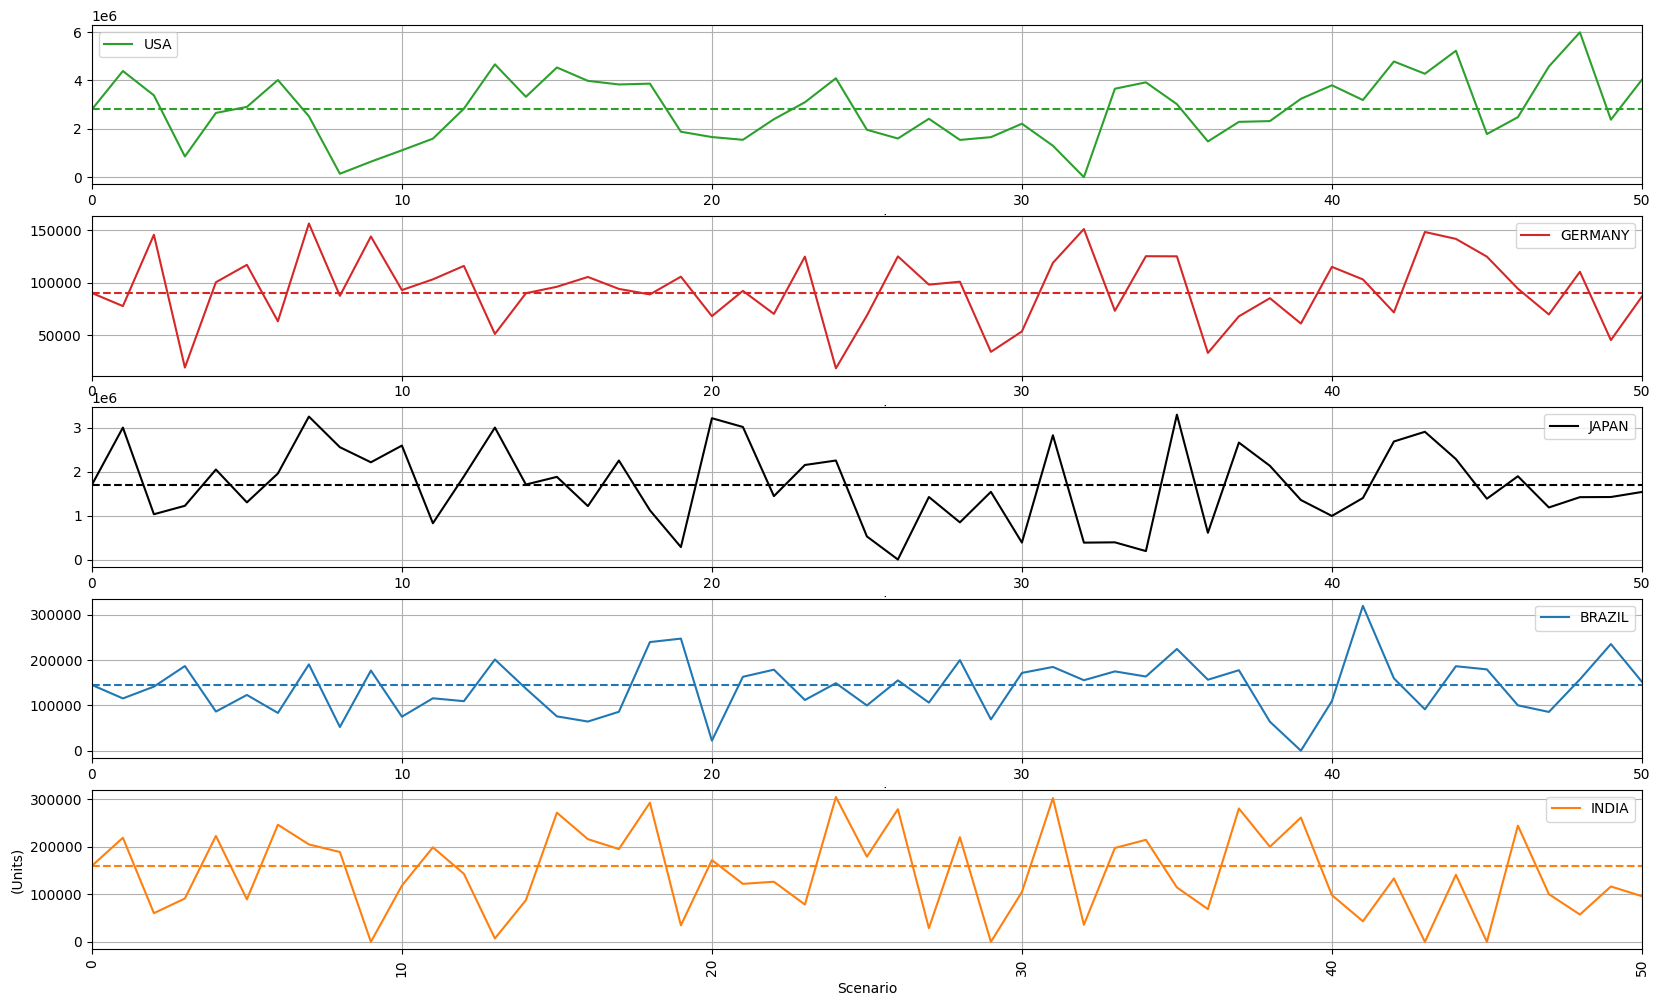

In [20]:
# Plot
figure, axes = plt.subplots(len(markets), 1)
colors = ['tab:green', 'tab:red', 'black', 'tab:blue', 'tab:orange']
for i in range(len(markets)):
    df_demand.plot(figsize=(20, 12), xlim=[0,N], x='scenario', y=markets[i], ax=axes[i], grid = True, color = colors[i])
    axes[i].axhline(df_demand[markets[i]].values[0], color=colors[i], linestyle="--")
plt.xlabel('Scenario')
plt.ylabel('(Units)')
plt.xticks(rotation=90)
plt.show()

#### Calculation: Initial Scenario

In [21]:
# Record results per scenario
list_scenario, list_status, list_results, list_totald, list_fixcost, list_varcost = [], [], [], [], [], []
# Initial Scenario
status_out, objective_out, y, x, fix, var = optimization_model(fixed_costs, var_cost, demand, 'Demand', cap)

# Add results
list_scenario.append('INITIAL')
total_demand = demand['Demand'].sum()
list_totald.append(total_demand)
list_status.append(status_out)
list_results.append(objective_out)
list_fixcost.append(fix)
list_varcost.append(var)
# Dataframe to record the solutions
df_bool = pd.DataFrame(data = [y[plant_name[i]].varValue for i in range(len(plant_name))], index = [i + '-' + s for s in size for i in loc], 
                        columns = ['INITIAL'])
df_bool.head()

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /opt/conda/lib/python3.10/site-packages/pulp/solverdir/cbc/linux/64/cbc /tmp/546c9ab221584459b4f7bc21bab68ffc-pulp.mps -timeMode elapsed -branch -printingOptions all -solution /tmp/546c9ab221584459b4f7bc21bab68ffc-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 15 COLUMNS
At line 131 RHS
At line 142 BOUNDS
At line 153 ENDATA
Problem MODEL has 10 rows, 35 columns and 60 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 6.46805e+07 - 0.00 seconds
Cgl0004I processed model has 10 rows, 35 columns (10 integer (10 of which binary)) and 60 elements
Cbc0038I Initial state - 1 integers unsatisfied sum - 0.07
Cbc0038I Solution found of 6.53175e+07
Cbc0038I Relaxing continuous gives 6.5118e+07
Cbc0038I Before mini branch and bound, 9 integers at bound fixed and 21 continuous
Cbc0038I Full problem 10 row

,INITIAL
USA-LOW,0.0
GERMANY-LOW,0.0
JAPAN-LOW,0.0
BRAZIL-LOW,0.0
INDIA-LOW,1.0


In [22]:
# Simulate all scenarios
demand_var = df_demand.drop(['scenario'], axis = 1).T

# Loop
for i in range(1, 50): # 0 is the initial scenario 
    # Calculations
    status_out, objective_out, y, x, fix, var = optimization_model(fixed_costs, var_cost, demand_var, i, cap)    
    
    # Append results
    list_status.append(status_out)
    list_results.append(objective_out)
    df_bool[i] = [y[plant_name[i]].varValue for i in range(len(plant_name))]
    list_fixcost.append(fix)
    list_varcost.append(var)
    total_demand = demand_var[i].sum()
    list_totald.append(total_demand)
    list_scenario.append(i)
# Final Results
# Boolean
df_bool = df_bool.astype(int)
df_bool.to_excel(f"{base_path}/boolean-{int(CV * 100)}PC.xlsx")
# Other Results
df_bool.head()

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /opt/conda/lib/python3.10/site-packages/pulp/solverdir/cbc/linux/64/cbc /tmp/d30f903a81f448bf98e873fbec66a478-pulp.mps -timeMode elapsed -branch -printingOptions all -solution /tmp/d30f903a81f448bf98e873fbec66a478-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 15 COLUMNS
At line 131 RHS
At line 142 BOUNDS
At line 153 ENDATA
Problem MODEL has 10 rows, 35 columns and 60 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 6.24167e+07 - 0.00 seconds
Cgl0004I processed model has 10 rows, 35 columns (10 integer (10 of which binary)) and 60 elements
Cbc0038I Initial state - 2 integers unsatisfied sum - 0.771284
Cbc0038I Pass   1: suminf.    0.00000 (0) obj. 6.51816e+07 iterations 6
Cbc0038I Solution found of 6.51816e+07
Cbc0038I Relaxing continuous gives 6.42099e+07
Cbc0038I Before mini branch and bo

,INITIAL,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49
USA-LOW,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
GERMANY-LOW,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
JAPAN-LOW,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
BRAZIL-LOW,0,0,1,1,0,0,0,0,0,1,0,1,0,1,1,1,0,1,0,1,0,0,1,1,0,1,0,0,0,0,0,1,1,0,1,1,1,0,0,1,1,0,1,0,0,0,0,0,0,1
INDIA-LOW,1,1,1,1,1,1,1,1,1,1,0,1,1,1,1,1,1,1,0,1,1,0,1,1,0,1,0,0,1,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,1


---

### Final Plot
#### Boolean Alone

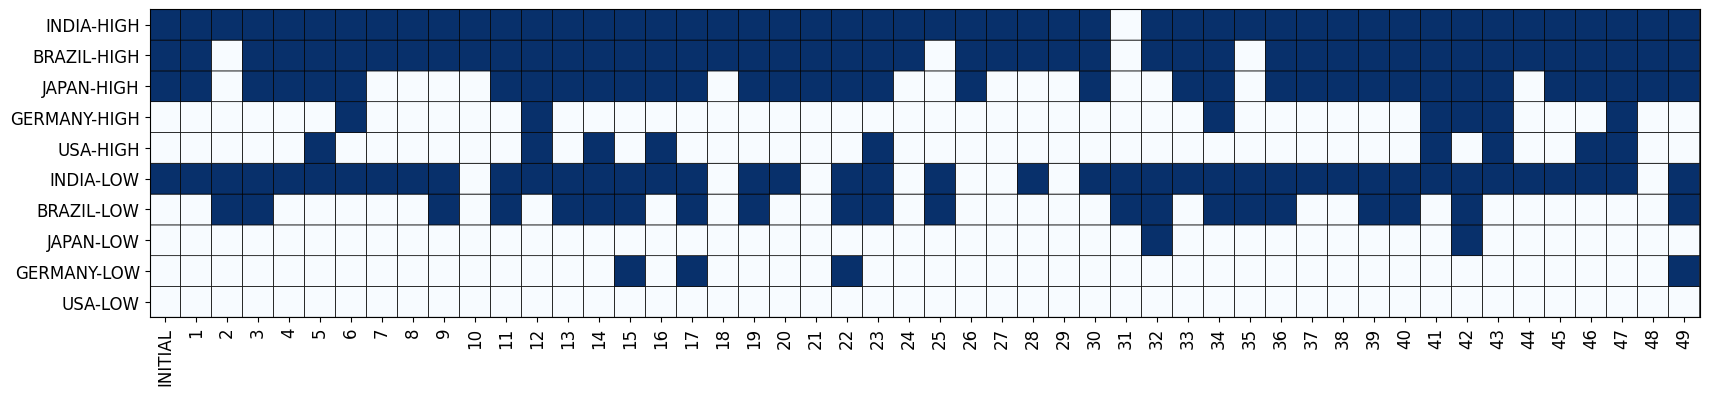

In [23]:
# Plot the Grid
plt.figure(figsize = (20,4))
plt.pcolor( df_bool, cmap = 'Blues', edgecolors='k', linewidths=0.5)   #
plt.xticks([i + 0.5 for i in range(df_bool.shape[1])], df_bool.columns, rotation = 90, fontsize=12)
plt.yticks([i + 0.5 for i in range(df_bool.shape[0])], df_bool.index, fontsize=12)
plt.show()

#### Add Demand 

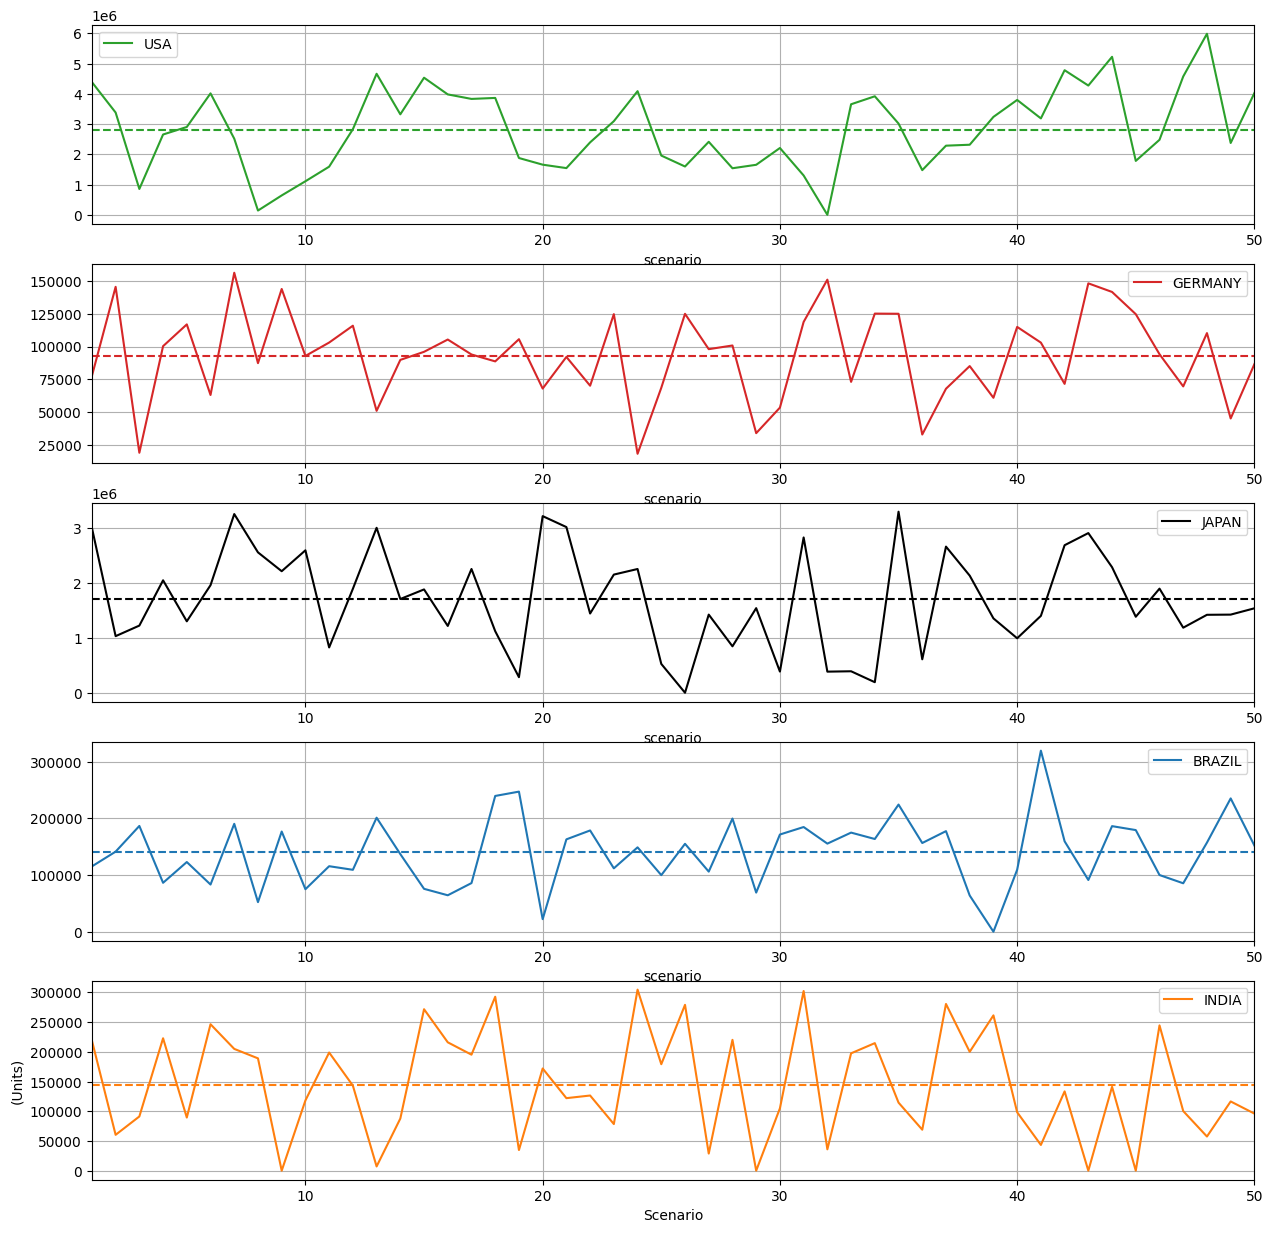

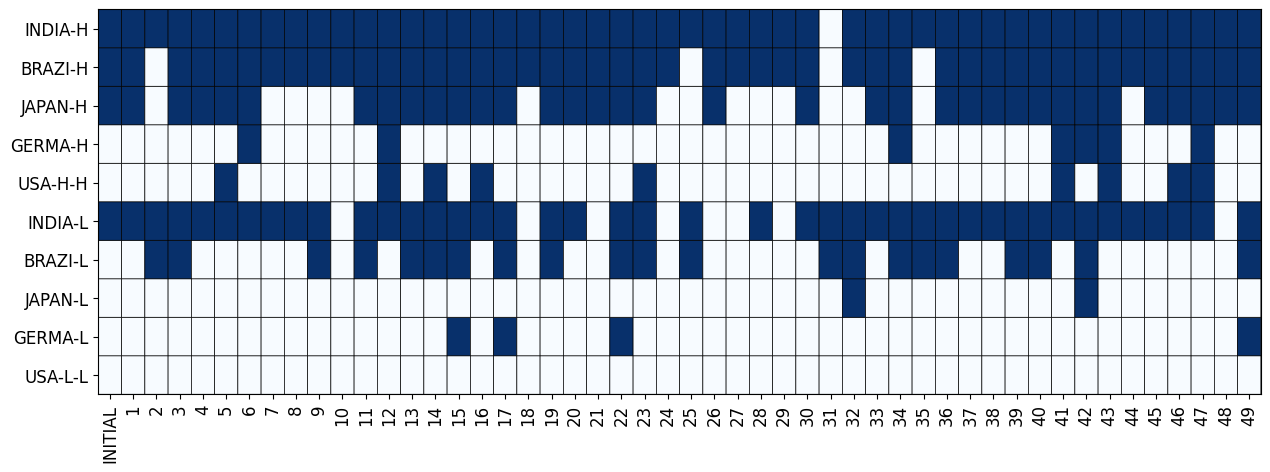

In [24]:
# Plot
figure, axes = plt.subplots(len(markets), 1)
colors = ['tab:green', 'tab:red', 'black', 'tab:blue', 'tab:orange']
for i in range(len(markets)):
    df_demand.plot(figsize=(15, 15), xlim=[1,N], x='scenario', y=markets[i], ax=axes[i], grid = True, color = colors[i])
    axes[i].axhline(df_demand[markets[i]].mean(), color=colors[i], linestyle="--")
plt.xlabel('Scenario')
plt.ylabel('(Units)')

# add the scenario plot
plt.figure(figsize=(15, 5))
plt.pcolor(df_bool, cmap = 'Blues', edgecolors='k', linewidths=0.5)   #
plt.xticks([i + 0.5 for i in range(df_bool.shape[1])], df_bool.columns, rotation = 90, fontsize=12)
plt.yticks([i + 0.5 for i in range(df_bool.shape[0])], [d[0:5]+ '-H' * ('HIGH' in d) + '-L' * ('LOW' in d) for d in df_bool.index], fontsize=12)
plt.xticks(rotation=90)
plt.show()

---

## Find the optimal Solution
#### Unique Combinations

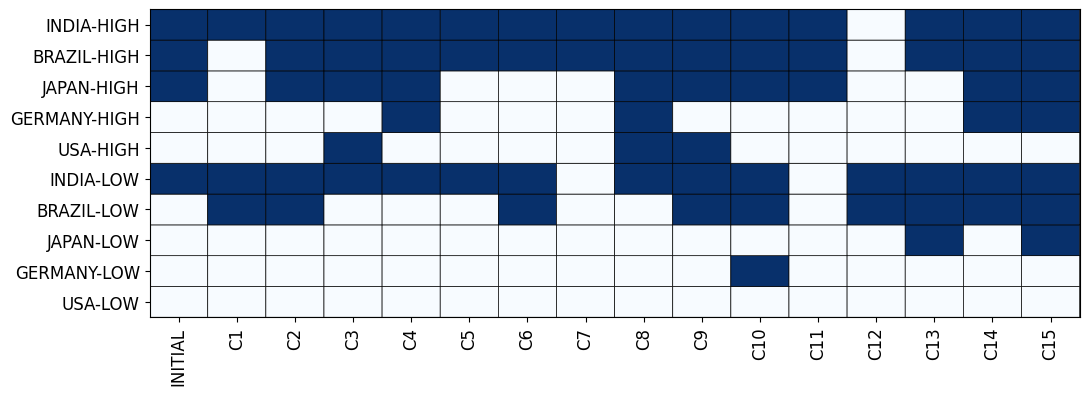

In [25]:
# Unique combinations
df_unique = df_bool.T.drop_duplicates().T
df_unique.columns = ['INITIAL'] + ['C' + str(i) for i in range(1, len(df_unique.columns))]
# Plot the Grid
plt.figure(figsize = (12,4))
plt.pcolor( df_unique, cmap = 'Blues', edgecolors='k', linewidths=0.5)   #
plt.xticks([i + 0.5 for i in range(df_unique.shape[1])], df_unique.columns, rotation = 90, fontsize=12)
plt.yticks([i + 0.5 for i in range(df_unique.shape[0])], df_unique.index, fontsize=12)
plt.show()

In [26]:
exp_name = "Version 1"
mlflow.set_experiment(exp_name)
experiment = mlflow.get_experiment_by_name(exp_name)
mlflow.autolog()

In [27]:
# Start MLflow run
with mlflow.start_run():
    # Log the DataFrame as an artifact
    df_unique_file = "df_unique.csv"
    df_unique.to_csv(df_unique_file, index=True)  # Save as CSV
    mlflow.log_artifact(df_unique_file)          # Log the CSV file
    
    # Plot the Grid
    plt.figure(figsize=(12, 4))
    plt.pcolor(df_unique, cmap='Blues', edgecolors='k', linewidths=0.5)
    plt.xticks(
        [i + 0.5 for i in range(df_unique.shape[1])],
        df_unique.columns,
        rotation=90,
        fontsize=12
    )
    plt.yticks(
        [i + 0.5 for i in range(df_unique.shape[0])],
        df_unique.index,
        fontsize=12
    )
    plt.title("Grid Plot of Unique Combinations", fontsize=14)
    plt.colorbar(label="Values")
    
    # Save and log the figure
    figure_file = "grid_plot.png"
    plt.savefig(figure_file, bbox_inches='tight')
    plt.close()
    mlflow.log_artifact(figure_file)  # Log the plot as an artifact